In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from Logistic import LogisticRegression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from SVM import SVM

### 文件读取、数据划分

In [3]:
def readfile():
    df = pd.read_csv('train_feature.csv')
    df.fillna(df.median(), inplace=True)
    X = np.array(df.values)
    y = np.loadtxt('train_label.csv', skiprows=1, dtype="int")
    return X, y

def drop_err(X, y):
    out = []
    for i in range(X[0].size):
        t = abs(np.mean(X.T[i]))
        for j in range(X.shape[0]):
            if abs(X[j][i]) > t * 5e2:
                out.append(j)
    return np.delete(X, out, axis=0), np.delete(y, out)

def choose_feature(X, y):
    clf = LR(penalty="l1")
    model = RFE(estimator=clf, n_features_to_select=85, step=5)
    X = model.fit_transform(X, y)
    model = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=60, step=5)
    X = model.fit_transform(X, y)
    return X, y

def partition(X, y):
    t = (int)(0.7 * y.size)
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:(t-1),:]
    X_test = X[t:(y.size-1),:]
    y_train = y[0:(t-1)]
    y_test = y[t:(y.size-1)]
    return X_train, X_test, y_train, y_test

def score(yp, y):
    return float(np.sum(yp == y))/y.size

X0, y0 = readfile()
X0, y0 = drop_err(X0, y0)
X0, y0 = choose_feature(X0, y0)

### LR参数

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

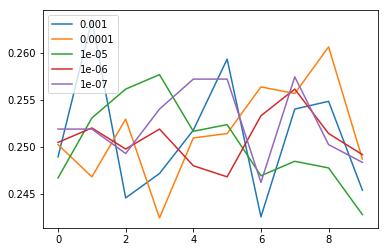

In [56]:
def lr_mul(X, y, p, X_t, it, lr):
    r = LogisticRegression(gamma = 1e-4)
    y1 = y
    for j in range(y1.size):
        if y1[j] in p: y1[j] = 1
        else: y1[j] = 0
    r.fit(X, y1, max_iter=it, lr=lr)
    return r.predict(X_t)

def test_lr(X, y, X_t, it, lr):
    yp1 = lr_mul(X, y, [0,1], X_t, it, lr)
    yp2 = lr_mul(X, y, [0,2], X_t, it, lr)
    yp3 = lr_mul(X, y, [0,3], X_t, it, lr)
    yp4 = lr_mul(X, y, [0], X_t, it, lr)
    yp5 = lr_mul(X, y, [1], X_t, it, lr)
    yp6 = lr_mul(X, y, [2], X_t, it, lr)
    yp7 = lr_mul(X, y, [3], X_t, it, lr)
    yp = np.zeros(yp1.size, dtype="int")
    x = np.zeros(4, dtype="int")
    for i in range(yp.size):
        now = np.array([yp1[i], yp2[i], yp3[i], yp4[i], yp5[i], yp6[i], yp7[i]])
        x[0] = np.sum(np.array([1,1,1,1,0,0,0]) == now)
        x[1] = np.sum(np.array([1,0,0,0,1,0,0]) == now)
        x[2] = np.sum(np.array([0,1,0,0,0,1,0]) == now)
        x[3] = np.sum(np.array([0,0,1,0,0,0,1]) == now)
        a = np.concatenate(np.argwhere(x == np.max(x)))
        yp[i] = np.random.choice(a)
    return yp

def con_lr(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            iter = i * 10 + 10
            lr = 1e-3 / 10 ** j
            for _ in range(3):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_lr(X_train, y_train, X_test, iter, lr)
                x[i] += score(yp, y_test)
            x[i] /= 3
        plt.plot(x, label=str(lr))
    plt.legend()


con_lr(X0, y0)

### 决策树参数

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

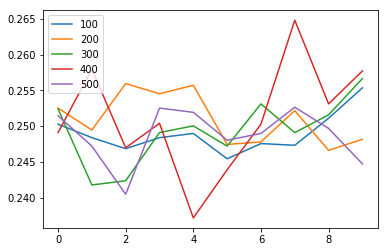

In [57]:
def test_tree(X, y, X_t, md, ml):
    a = DecisionTreeClassifier(max_depth=md, min_samples_leaf=ml)
    a.fit(X, y)
    return a.predict(X_t)

def con_tree(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            md = i * 2 + 2
            ml = 100 * j + 100
            for _ in range(3):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_tree(X_train, y_train, X_test, md, ml)
                x[i] += score(yp, y_test)
            x[i] /= 3
        plt.plot(x, label=str(ml))
    plt.legend()


con_tree(X0, y0)

### 神经网络参数

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

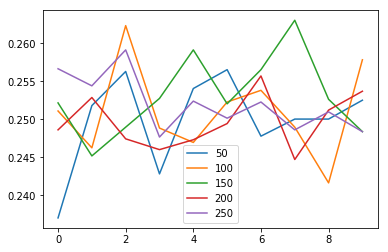

In [58]:
def test_mlp(X, y, X_t, hl, mi):
    b = MLPClassifier(hidden_layer_sizes=hl, max_iter=mi)
    b.fit(X, y)
    return b.predict(X_t)

def con_mlp(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            hl = i * 10 + 10
            mi = 50 * j + 50
            for _ in range(3):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_mlp(X_train, y_train, X_test, hl, mi)
                x[i] += score(yp, y_test)
            x[i] /= 3
        plt.plot(x, label=str(mi))
    plt.legend()


con_mlp(X0, y0)

### XGBoost参数

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

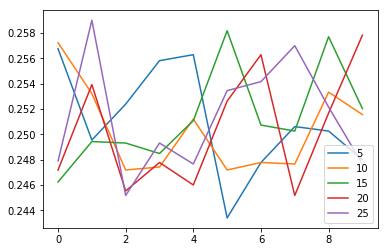

In [59]:
def test_xgb(X, y, X_t, ne, md):
    c = XGBClassifier(n_estimators=ne, max_depth=md)
    c.fit(X, y)
    return c.predict(X_t)

def con_xgb(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            ne = i * 10 + 10
            md = 5 * j + 5
            for _ in range(3):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_xgb(X_train, y_train, X_test, ne, md)
                x[i] += score(yp, y_test)
            x[i] /= 3
        plt.plot(x, label=str(md))
    plt.legend()


con_xgb(X0, y0)

### SVM参数

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

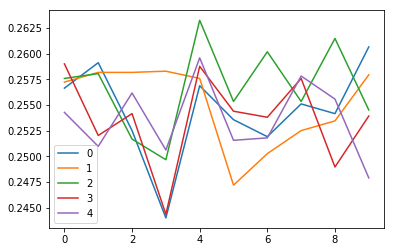

In [60]:
def svm_mul(X, y, p, X_t,it, c):
    r = SVM(X[0].size)
    y1 = y
    for j in range(y1.size):
        if y1[j] in p: y1[j] = 1
        else: y1[j] = -1
    r.fit(X, y1, choose_method="random", iter=it, C=c)
    return r.predict(X_t)

def test_svm(X, y, X_t, it, c):
    yp1 = svm_mul(X, y, [0,1], X_t, it, c)
    yp2 = svm_mul(X, y, [0,2], X_t, it, c)
    yp3 = svm_mul(X, y, [0,3], X_t, it, c)
    yp4 = svm_mul(X, y, [0], X_t, it, c)
    yp5 = svm_mul(X, y, [1], X_t, it, c)
    yp6 = svm_mul(X, y, [2], X_t, it, c)
    yp7 = svm_mul(X, y, [3], X_t, it, c)
    yp = np.zeros(yp1.size, dtype="int")
    x = np.zeros(4, dtype="int")
    for i in range(yp.size):
        now = np.array([yp1[i], yp2[i], yp3[i], yp4[i], yp5[i], yp6[i], yp7[i]])
        x[0] = np.sum(np.array([1,1,1,1,-1,-1,-1]) == now)
        x[1] = np.sum(np.array([1,-1,-1,-1,1,-1,-1]) == now)
        x[2] = np.sum(np.array([-1,1,-1,-1,-1,1,-1]) == now)
        x[3] = np.sum(np.array([-1,-1,1,-1,-1,-1,1]) == now)
        a = np.concatenate(np.argwhere(x == np.max(x)))
        yp[i] = np.random.choice(a)
    return yp

def con_svm(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            iter = i * 10 + 10
            c = j * 0.5 + 0.5
            for _ in range(3):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_svm(X_train, y_train, X_test, iter, c)
                x[i] += score(yp, y_test)
            x[i] /= 3
        plt.plot(x, label=str(j))
    plt.legend()


con_svm(X0, y0)

### SVM参数2

0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,0 0,1 1,1 2,1 3,1 4,1 5,1 6,1 7,1 8,1 9,1 0,2 1,2 2,2 3,2 4,2 5,2 6,2 7,2 8,2 9,2 0,3 1,3 2,3 3,3 4,3 5,3 6,3 7,3 8,3 9,3 0,4 1,4 2,4 3,4 4,4 5,4 6,4 7,4 8,4 9,4 

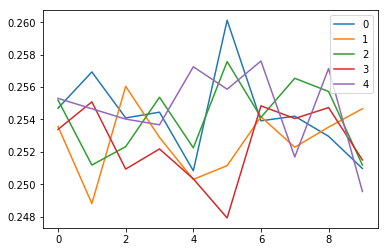

In [5]:
def svm_mul2(X, y, p, X_t,it, c):
    r = SVM(X[0].size)
    y1 = y
    for j in range(y1.size):
        if y1[j] in p: y1[j] = 1
        else: y1[j] = -1
    r.fit(X, y1, choose_method="random", iter=it, C=c)
    return r.predict(X_t)

def test_svm2(X, y, X_t, it, c):
    yp1 = svm_mul2(X, y, [0,1], X_t, it, c)
    yp2 = svm_mul2(X, y, [0,2], X_t, it, c)
    yp3 = svm_mul2(X, y, [0,3], X_t, it, c)
    yp4 = svm_mul2(X, y, [0], X_t, it, c)
    yp5 = svm_mul2(X, y, [1], X_t, it, c)
    yp6 = svm_mul2(X, y, [2], X_t, it, c)
    yp7 = svm_mul2(X, y, [3], X_t, it, c)
    yp = np.zeros(yp1.size, dtype="int")
    x = np.zeros(4, dtype="int")
    for i in range(yp.size):
        now = np.array([yp1[i], yp2[i], yp3[i], yp4[i], yp5[i], yp6[i], yp7[i]])
        x[0] = np.sum(np.array([1,1,1,1,-1,-1,-1]) == now)
        x[1] = np.sum(np.array([1,-1,-1,-1,1,-1,-1]) == now)
        x[2] = np.sum(np.array([-1,1,-1,-1,-1,1,-1]) == now)
        x[3] = np.sum(np.array([-1,-1,1,-1,-1,-1,1]) == now)
        a = np.concatenate(np.argwhere(x == np.max(x)))
        yp[i] = np.random.choice(a)
    return yp

def con_svm2(X, y):
    plt.figure()
    for j in range(5):
        x = np.zeros(10)
        for i in range(10):
            print(str(i) + "," + str(j), end=" ")
            iter = i * 10 + 10
            c = j * 0.5 + 0.5
            for _ in range(10):
                X_train, X_test, y_train, y_test = partition(X, y)
                yp = test_svm2(X_train, y_train, X_test, iter, c)
                x[i] += score(yp, y_test)
            x[i] /= 10
        plt.plot(x, label=str(j))
    plt.legend()


con_svm2(X0, y0)